In [1]:
# publicly shared dataset on mental health in tech and similar workplaces downloaded from:
# https://www.kaggle.com/datasets/osmi/mental-health-in-tech-2016

# load dataset into a dataframe
import pandas as pd
data = pd.read_csv("data/mental_tech.csv")

## Data preprocessing

In [2]:
# data.info() indicated that the majority of variables have 1000-1500 non-null values
# but some have < 1000
# drop columns with < 1000 non-null values
data.dropna(axis='columns', thresh=1000, inplace=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 48 columns):
 #   Column                                                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                                                          --------------  -----  
 0   Are you self-employed?                                                                                                                          1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                      1146 non-null   object 
 2   Is your employer primarily a tech company/organization?                                                                                         1146 non-null   float64
 3   Does your employer prov

Column names are very long strings, so columns will be identified by index until renamed with short names.

I am interested in predicting belief that being identified as a person with a mental health issue would hurt career (index 31, short name: hurt_career) using:  
5 current employer discusses mental health (current_discuss)  
6 current employer offers mental health resources (current_resources)  
13 belief that current employer takes mental health as seriously as physical health (current_vs_physical)  
18 previous employer discusses mental health (previous_discuss)  
19 previous employer offers mental health resources (previous_resources)  
25 belief that previous employer takes mental health as seriously as physical health (previous_vs_physical)  
34 observed/experienced bad response to mental health issue in workplace (bad_response)  
35 family hx mental illness (family_hx)  
38 diagnosed with mental illness (diagnosed)  
42 age (age)  
43 gender (gender)  
47 work remotely (remote)

In [4]:
# reduce dataset to variables of interest and rename columns with short names
data = data.iloc[:,[31,5,6,13,18,19,25,34,35,38,42,43,47]]
data.columns = ['hurt_career', 'current_discuss', 'current_resources', 'current_vs_physical',
               'previous_discuss', 'previous_resources', 'previous_vs_physical', 'bad_response',
               'family_hx', 'diagnosed', 'age', 'gender', 'remote']

In [5]:
# age is only int dtype, the rest are object
data['age'].describe()

count    1433.000000
mean       34.286113
std        11.290931
min         3.000000
25%        28.000000
50%        33.000000
75%        39.000000
max       323.000000
Name: age, dtype: float64

Min and max indicate some weird age values.  
These could indicate some unreliable samples.  
Exploring further:

In [6]:
# how many age values under 16?
sum(data['age'] < 16)

2

In [7]:
# which samples?
data.index[data['age'] < 16]

Int64Index([656, 808], dtype='int64')

Manual inspection of these samples revealed 808 could be legitimate response of age 15 doing freelance work.  
656 reports age 3, so likely an unreliable record that can be dropped.

In [8]:
# how many age values over 80?
sum(data['age'] > 80)

2

In [9]:
# which samples?
data.index[data['age'] > 80]

Int64Index([372, 564], dtype='int64')

Manual inspection of these samples revealed they are both likely to be unreliable records that can be dropped.

In [10]:
# dropping unreliable samples
data = data.drop(index=[656, 372, 564])

In [11]:
# how many samples have null values for more than half of variables?
sum(data.isnull().sum(axis=1) > 6)

14

In [12]:
# dropping samples with many null values
null_idx = data.index[data.isnull().sum(axis=1) > 6]
data = data.drop(index=null_idx)

In [13]:
# examine gender responses
pd.set_option("display.max_rows", 70)
data['gender'].value_counts()

Male                                                                                                                                                             604
male                                                                                                                                                             243
Female                                                                                                                                                           152
female                                                                                                                                                            94
M                                                                                                                                                                 85
m                                                                                                                                                                 79
F         

In [14]:
# gender was clearly a free-response item, therefore will be recoded into more useful groups: female, male, other
data['gender'] = data['gender'].map({'Male': 'male', 'male': 'male', 'Female': 'female', 'female': 'female', 'M': 'male', 'm': 'male', 'F': 'female', 'f': 'female', 'Male ': 'male', 
                                    'Female ': 'female', 'woman': 'female', 'non-binary': 'other', 'Woman': 'female', 'man': 'male', 'female ': 'female', 'Nonbinary': 'other', 'male ': 'male',
                                    'Male (cis)': 'male', 'Man': 'male', 'Agender': 'other', 'Cis-woman': 'female', 'Queer': 'other', 'Dude': 'male', 'Fluid': 'other', 
                                    "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ": 'male',
                                    'mail': 'male', 'M|': 'male', 'Male/genderqueer': 'other', 'Transgender woman': 'other', 'fem': 'female', 'AFAB': 'female', 'cis man': 'male',
                                    'female-bodied; no feelings about gender': 'other', 'Genderflux demi-girl': 'other', 'human': 'other', 'Female (props for making this a freeform field, though)': 'female',
                                    ' Female': 'female', 'Unicorn': 'other', 'Cis Male': 'male', 'cisdude': 'male', 'Genderqueer': 'other', 'Male (trans, FtM)': 'other', 'none of your business': 'other',
                                    'mtf': 'other', 'genderqueer woman': 'other', 'I identify as female.': 'female', 'Bigender': 'other', 'Female assigned at birth ': 'female', 'fm': 'female',
                                    'Cis female ': 'female', 'Transitioned, M2F': 'other', 'Genderfluid (born female)': 'other', 'Other/Transfeminine': 'other', 'Female or Multi-Gender Femme': 'other',
                                    'female/woman': 'female', 'Cis male': 'male', 'Male.': 'male', 'Androgynous': 'other', 'male 9:1 female, roughly': 'other', 'nb masculine': 'other', 
                                    'Cisgender Female': 'female', 'Sex is male': 'male', 'genderqueer': 'other', 'cis male': 'male', 'Human': 'other', 'Genderfluid': 'other', 'Enby': 'other',
                                    'Malr': 'male', 'MALE': 'male'})

In [15]:
# examine how many unique values in each column to check for any other categorical variables that may have been free-response
# or otherwise have a very large number of categories
for c in range(data.shape[1]):
    print(len(data.iloc[:,c].unique()), "unique values in column", data.columns[c])

5 unique values in column hurt_career
4 unique values in column current_discuss
4 unique values in column current_resources
4 unique values in column current_vs_physical
5 unique values in column previous_discuss
4 unique values in column previous_resources
5 unique values in column previous_vs_physical
5 unique values in column bad_response
3 unique values in column family_hx
2 unique values in column diagnosed
49 unique values in column age
4 unique values in column gender
3 unique values in column remote


These results look good (except hurt_career, the target variable), but I still manually examined the response options for each remaining categorical variable using value_counts().  
I did not observe any issues that would need to be addressed.

In [16]:
# inspect response options and counts for potential target variable
data['hurt_career'].value_counts()

Maybe                         581
Yes, I think it would         556
No, I don't think it would    144
Yes, it has                   105
No, it has not                 30
Name: hurt_career, dtype: int64

In [17]:
# define target variable
# reduce from 5 categories to 2
# 0 indicates person is not confident that mental health identity would hurt career
# 1 indicates person is confident that mental health identity would hurt career
target = data['hurt_career'].map({'Maybe': 0, "No, I don't think it would": 0, 'No, it has not': 0, 
                                   'Yes, I think it would': 1, 'Yes, it has': 1})
print(target.value_counts())
data = data.drop(columns='hurt_career')

0    755
1    661
Name: hurt_career, dtype: int64


## Histogram gradient boosting classifier pipeline and optimization

#### Preprocessor

In [18]:
# identify categorical data columns for encoding
categorical_columns = ['current_discuss', 'current_resources', 'current_vs_physical',
               'previous_discuss', 'previous_resources', 'previous_vs_physical', 'bad_response',
               'family_hx', 'diagnosed', 'gender', 'remote']

# create preprocessor for categorical data
# the ColumnTransformer will apply the preprocessor only to categorical columns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)],
    remainder = 'passthrough')

I am applying ordinal encoding to all categorical variables, regardless of whether they are truly ordinal in nature.  
This is appropriate and more efficient for tree-based models, which I will be applying here.

#### Grid search to optimize hyperparameters

In [19]:
# create full model pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
hgbc = make_pipeline(preprocessor, HistGradientBoostingClassifier())

In [20]:
# prepare a grid search over values for key hyperparameters
from sklearn.model_selection import GridSearchCV
params_to_search = {
    'histgradientboostingclassifier__learning_rate': (0.01, 0.05, 0.1, 0.5, 1, 2),
    'histgradientboostingclassifier__max_leaf_nodes': (5, 10, 20, 30, 40)}

# grid search with 10 stratified shuffle split cross-validation 
from sklearn.model_selection import StratifiedShuffleSplit
model_grid_search = GridSearchCV(hgbc, param_grid=params_to_search, n_jobs=2, cv=StratifiedShuffleSplit(test_size=0.2))

In [21]:
# run grid search
# embedding model_grid_search within outer cross-validation 
# this means each grid search will be optimized on a different split of training data
# and generalization performance of the best parameters from each grid search will be tested and stored 
from sklearn.model_selection import cross_validate
cv_results = cross_validate(model_grid_search, data, target, cv=StratifiedShuffleSplit(test_size=0.2), n_jobs=2, return_estimator=True)

In [26]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingclassifier__learning_rate': 0.05, 'histgradientboostingclassifier__max_leaf_nodes': 5}
with accuracy of 0.620
Best hyperparameters for split #2:
{'histgradientboostingclassifier__learning_rate': 0.05, 'histgradientboostingclassifier__max_leaf_nodes': 5}
with accuracy of 0.644
Best hyperparameters for split #3:
{'histgradientboostingclassifier__learning_rate': 0.1, 'histgradientboostingclassifier__max_leaf_nodes': 5}
with accuracy of 0.616
Best hyperparameters for split #4:
{'histgradientboostingclassifier__learning_rate': 0.05, 'histgradientboostingclassifier__max_leaf_nodes': 5}
with accuracy of 0.651
Best hyperparameters for split #5:
{'histgradientboostingclassifier__learning_rate': 0.05, 'histgradientboostingclassifier__max_leaf_nodes': 5}
with accuracy of 0.680
Best hyperparameters for split #6:
{'histgradientboostingclassifier__learning_rate': 0.01, 'histgradientboostingclassifier__max_leaf_nodes': 10}
with accuracy of 0.65

The most consistent best combination of hyperparameters is learning rate of 0.05 and max leaf nodes of 5.

#### Validation curves to examine fit

In [54]:
# generate validation curve for learning rate
from sklearn.model_selection import validation_curve
learning_rate_values = [0.005, 0.01, 0.05, 0.1, 0.5, 1] # centering around previous optimal value
hgbc.set_params(histgradientboostingclassifier__max_leaf_nodes=5)
train_scores, test_scores = validation_curve(
    hgbc, data, target, param_name='histgradientboostingclassifier__learning_rate', param_range=learning_rate_values, scoring='accuracy', n_jobs=2)

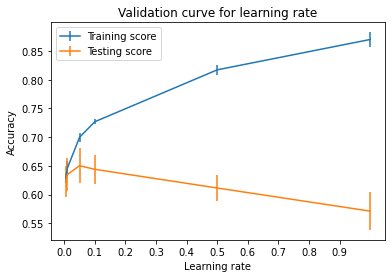

In [55]:
# plot validation curve for learning rate
import matplotlib.pyplot as plt
import numpy as np
plt.errorbar(learning_rate_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(learning_rate_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 1, 0.1))
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
_ = plt.title("Validation curve for learning rate")

Learning rate of 0.05 yields the best fitting model (given max leaf nodes of 5).

In [56]:
# generate validation curve for max leaf nodes
max_leaf_nodes_values = [2, 3, 4, 5, 7, 10, 15, 20] # centering around previous optimal value
hgbc.set_params(histgradientboostingclassifier__learning_rate=0.05)
train_scores, test_scores = validation_curve(
    hgbc, data, target, param_name='histgradientboostingclassifier__max_leaf_nodes', param_range=max_leaf_nodes_values, scoring='accuracy', n_jobs=2)

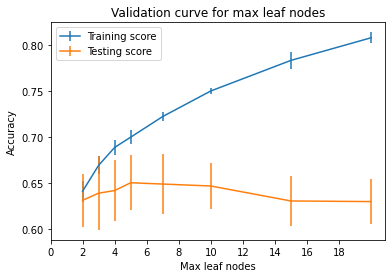

In [57]:
# plot validation curve for max leaf nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 20, 2))
plt.xlabel("Max leaf nodes")
plt.ylabel("Accuracy")
_ = plt.title("Validation curve for max leaf nodes")

Max leaf nodes of 5 yields the best fitting model (given learning rate of 0.05).

## Model evaluation

In [27]:
# run dummy classification model for baseline comparison
# this model will just predict the most common class in the target
from sklearn.dummy import DummyClassifier
dummy_results = cross_validate(DummyClassifier(), data, target, cv=StratifiedShuffleSplit(test_size=0.2))
print('The accuracy of the dummy classification model is: ' 
      f"{dummy_results['test_score'].mean():.3f} +/- {dummy_results['test_score'].std():.3f}") 

The accuracy of the dummy classification model is: 0.532 +/- 0.000


In [49]:
# run HGBC model for performance comparison
hgbc.set_params(histgradientboostingclassifier__learning_rate=0.05, histgradientboostingclassifier__max_leaf_nodes=5)
hgbc_results = cross_validate(hgbc, data, target, cv=StratifiedShuffleSplit(test_size=0.2), n_jobs=2)
print('The accuracy of the HGBC model is: ' 
      f"{hgbc_results['test_score'].mean():.3f} +/- {hgbc_results['test_score'].std():.3f}\n"
      f"The HGBC model improves upon the accuracy of the dummy model by {hgbc_results['test_score'].mean()-dummy_results['test_score'].mean():.3f}")

The accuracy of the HGBC model is: 0.651 +/- 0.022
The HGBC model improves upon the accuracy of the dummy model by 0.119


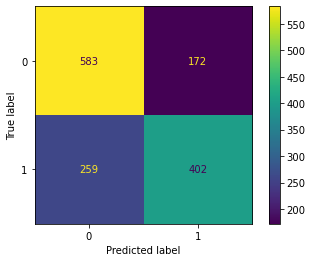

In [70]:
# generate confusion matrix to assess model performance in more detail
# (performance is a little inflated since training and testing on the full dataset,
# but just getting a rough idea of quadrant proportions to look for anything unusual)
hgbc.fit(data, target)
from sklearn.metrics import ConfusionMatrixDisplay
_ = ConfusionMatrixDisplay.from_estimator(hgbc, data, target)

#### Learning curve to evaluate sample size adequacy

In [59]:
train_size_values = np.linspace(0.1, 1, num=8)
from sklearn.model_selection import learning_curve
learn_results = learning_curve(hgbc, data, target, train_sizes=train_size_values, scoring='accuracy', n_jobs=2)
train_size, train_scores, test_scores = learn_results[:3]

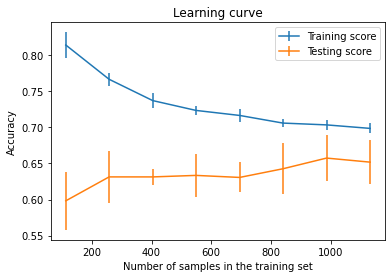

In [66]:
# plot learning curve
plt.errorbar(train_size, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(train_size, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
_ = plt.title("Learning curve")

These results suggest that the model is reasonably well fitted, however modest gains in predictive performance may be possible with additional data,  
as the curves have not fully flattened by the full training size.

## Conclusions

Overall, I was able to predict the beliefs of employees in tech and related industries  
regarding whether being identified as having a mental health issue would hurt their career  
based on demographics, mental illness history, remote working status, and  
experiences with current and previous employers regarding mental health.  
The prediction accuracy of the model (65%) was significantly better than a baseline model  
that did not leverage these features.